# Market risk lesson, practice.
## 1.How to calculate VaR
## 1.1 Parametric, Cornish Fisher and Historical VaR
In this section we will calculate the VaR of an equity with parametric, CF and Historical approach
Let first load a couple of libraries:

In [1]:
from pandas_datareader import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.stats import kurtosis
from scipy.stats import skew

We will now download the time series of Standard & Poor's 500 index, at weekly timestep:

In [2]:
sp500 = data.DataReader("XSPX.MI", 
                       start='2018-3-31', 
                       end='2021-3-31', 
                       data_source='yahoo')['Adj Close']
sp500=sp500.resample('W').last()

First thing to mind: why I downloaded 3 years of data? Well... that has to do with the numerosity of data.
We need to extract the 95th percentile. That means that with 1y of data we are lefth with two/three returns in the tail of the distribution. With three years of data we have 8 values, much better:

In [3]:
len(sp500)

157

In [4]:
len(sp500)*0.95

149.15

In [5]:
52*0.95

49.4

In general the variance of a percentile extimator can be calculated using its asymptotical limit:
$$ \sigma^2 = \frac{1}{f(x)}\frac{P(1-P)}{N} $$
where $f(x)$ is the pdf of the random variabole of which we are extimating the percentile.

### Parametric and Cornish-Fisher VaR

In order to calculate VaR we need the logaritmic differences of the time series:
$$
Y_t=log(X_t/X_{t-1})
$$

In [6]:
sp500_ylds=np.log(sp500).diff()[1:]

In [7]:
sp500_ylds

Date
2018-04-15    0.008323
2018-04-22    0.006969
2018-04-29    0.015061
2018-05-06    0.007949
2018-05-13    0.027640
                ...   
2021-03-07   -0.007914
2021-03-14    0.047380
2021-03-21    0.002416
2021-03-28    0.012945
2021-04-04    0.016066
Freq: W-SUN, Name: Adj Close, Length: 156, dtype: float64

We need to cut the first value since we do not have a difference for that value. Now we have our random variable. Let's have a look at the distribution:

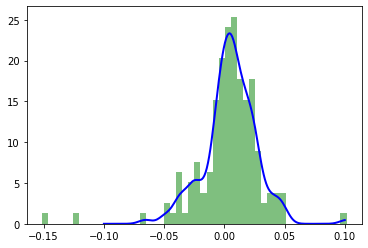

In [8]:
t_range = np.linspace(-0.1,0.1,200)
plt.hist(sp500_ylds, 50, density=1, facecolor='green', alpha=0.5);
pdf_estimator=gaussian_kde(sp500_ylds,bw_method=0.2)
plt.plot(t_range,pdf_estimator(t_range),lw="2",color="blue")

Well, the distributions seams quite normal... Let's look at what parametric and Cornish Fisher VaR will look like. For parametric VaR we need to calculate:
$$
\textrm{ParametricVaR}_{0.95}=\Phi^{-1}(0.95) \times \sigma_Y
$$

In [9]:
VaR95_parametric_week=np.std(sp500_ylds) * norm.ppf(0.05)

In [10]:
VaR95_parametric_week

-0.04444717451219423

Ok, so we can expect to loose no more than 4.44% per cent in a week. Let's look at Cornish Fisher VaR (remember formulas from the lesson!). We have

In [11]:
sp500_skew=skew(sp500_ylds)
sp500_kurt=kurtosis(sp500_ylds)
sp500_vol=np.std(sp500_ylds)
q=norm.ppf(0.05)
z_CornishFisher=q+sp500_skew*(q**2-1)/6+(q**3-3*q)*sp500_kurt/24-(2*q**3-5*q)/36*sp500_skew**2
VaR95_CF_week=np.std(sp500_ylds) * z_CornishFisher

In [12]:
VaR95_CF_week

-0.05102929875116967

Cornish Fisher VaR is much higher, we are looking at 5.10%, it is 16% more respect parametric VaR. Why that?
The answer is because the distribution of returns is not very close to a normal distribution, se we are not in the hypotheses of the parametric VaR.
Let's look at historical VaR. Well that's simple:

In [13]:
VaR95_Hist_week=np.percentile(sp500_ylds,5)

In [14]:
VaR95_Hist_week

-0.03695481811222279

Well... that's strange: historical VaR is smaller than parametric and historical VaR. Why? Let me give you a clue...

In [15]:
np.log(sp500[-1]/sp500[0])

0.5136942939601179

We need to remove bias! Let's do that:

In [16]:
sp500_ylds_modified=sp500_ylds-np.mean(sp500_ylds)

In [17]:
VaR95_Hist_week=np.percentile(sp500_ylds_modified,5)

In [18]:
VaR95_Hist_week

-0.040247730252992775

So we have now three VaRs, parametri, CF and historical. Let's loot at the "future" of SP500 in order to see if our measure are good...

In [19]:
sp500_future = data.DataReader("XSPX.MI", 
                       start='2021-3-31', 
                       end='2021-4-21', 
                       data_source='yahoo')['Adj Close']

In [20]:
sp500_future

Date
2021-03-31    64.000000
2021-04-01    64.279999
2021-04-06    65.080002
2021-04-07    64.730003
2021-04-08    64.910004
2021-04-09    65.209999
2021-04-12    65.360001
2021-04-13    65.419998
2021-04-14    65.370003
2021-04-15    65.680000
2021-04-16    65.820000
2021-04-19    65.459999
2021-04-20    64.730003
2021-04-21    65.209999
Name: Adj Close, dtype: float64

In [21]:
np.log(sp500_future[-1]/sp500_future[0])

0.018729734005761858

We cannot decide. We need to do some backtesting...

## 1.2.Backtesting of VaR

In [22]:
sp500_btest = data.DataReader("XSPX.MI", 
                       start='2015-3-31', 
                       end='2021-3-31', 
                       data_source='yahoo')['Adj Close']
sp500_btest=sp500_btest.resample('W').last()
sp500_ylds_btest=np.log(sp500_btest).diff()[1:]

In [23]:
len(sp500_btest)

314

Ok, let's test parametric VaR first.

In [24]:
TestYield_btest=[]
ParametricVaR_btest=[]
TestFail=0
for i in range(159,314):
    BaseYields=sp500_ylds_btest[(i-159):(i-2)]
    TestYield_btest.append(sp500_ylds_btest[i-1])
    ParametricVaR_btest.append(np.std(BaseYields)*norm.ppf(0.05))
    if TestYield_btest[-1]<ParametricVaR_btest[-1]:
        TestFail+=1

What we have done is a becktest: we calculated VaR for 3 years and compared the VaR with the actual yield that has been observed in the next week. We have:

In [25]:
len(TestYield_btest)

155

samples, so, roughly speaking, we expect 155 x 0.05 = 7.75 failures.

In [26]:
TestFail

10

10 failures... is that good or not? The binomial distribution has an answer:
$$
\textrm{Binom}(x \leq 10;5\%;155)=84.53\%
$$
The p-value is 1-84.53%, about 15.5% so we cannot reject the hypothesis that parametric VaR is good. Let's have a look at the backtesting chart:

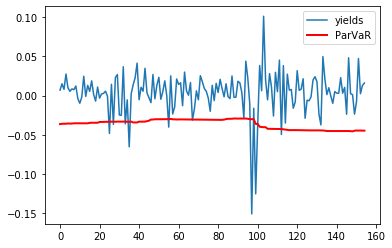

In [27]:
plt.plot(TestYield_btest,label="yields")
plt.plot(ParametricVaR_btest,color="red",lw=2,label="ParVaR")
plt.legend()

Let's do the same thing with historical VaR...

In [28]:
HSVaR_btest=[]
TestFail=0
for i in range(159,314):
    BaseYields=sp500_ylds_btest[(i-159):(i-2)]
    BaseYields=BaseYields-np.mean(BaseYields)
    HSVaR_btest.append(np.percentile(BaseYields,5))
    if (TestYield_btest[i-(313-154)]<HSVaR_btest[-1]):
        TestFail+=1

In [29]:
TestFail

8

In the end of the day, historical VaR not that bad ... Let's look at the chart:

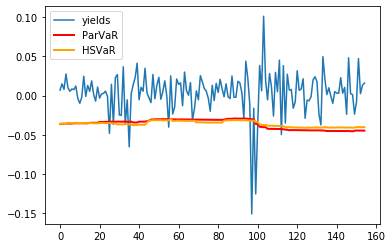

In [30]:
plt.plot(TestYield_btest,label="yields")
plt.plot(ParametricVaR_btest,color="red",lw=2,label="ParVaR")
plt.plot(HSVaR_btest,color="orange",lw=2,label="HSVaR")
plt.legend()

Cornish Fisher VaR will react more heavily. Let's look at it:

In [31]:
CFVaR_btest=[]
TestFail=0
q=norm.ppf(0.05)
for i in range(159,314):
    BaseYields=sp500_ylds_btest[(i-159):(i-2)]
    BaseYields=BaseYields-np.mean(BaseYields)
    aux_skew=skew(BaseYields)
    aux_kurt=kurtosis(sp500_ylds)
    aux_vol=np.std(sp500_ylds)
    z_CornishFisher=q+aux_skew*(q**2-1)/6+(q**3-3*q)*aux_kurt/24-(2*q**3-5*q)/36*aux_skew**2
    CFVaR_btest.append(aux_vol*z_CornishFisher)
    if (TestYield_btest[i-(313-154)]<CFVaR_btest[-1]):
        TestFail+=1

In [32]:
TestFail

4

Uh oh... This time the binomial test rings an alarm bell:
$$
\textrm{Binom}(x \leq 4;5\%;155)=10.87\%
$$
At 10% we nearly decide that CF VaR is overextimated! Let's look at the chart:

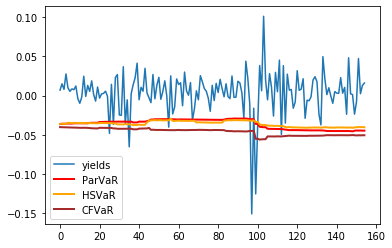

In [33]:
plt.plot(TestYield_btest,label="yields")
plt.plot(ParametricVaR_btest,color="red",lw=2,label="ParVaR")
plt.plot(HSVaR_btest,color="orange",lw=2,label="HSVaR")
plt.plot(CFVaR_btest,color="brown",lw=2,label="CFVaR")
plt.legend()

CF VaR will react heavily to large returns, due to the 0 breakdown property of Kurtosis and skew.

# 2.Hedging!

In this excercise we will try to hedge a long position in equity with an option. Lets put out some data:
* option are call and put, with implied volatility 10% and risk free rate 1%, expiry 3 months
* the minimun notional si 100 shares per option
* strike prices will vary any 2.5 EUR
* our position is 1500 shares, valued 15.5 eur each
* we need a delta neutral position


To solve the exercise, lets define a couple of functions:

In [34]:
def Delta(OpType,Notional,S,K,r,T,sigma):
    delta=0
    if (OpType=="Call"):
        if S>K:
            delta=1
        if T>0:
            d1=(np.log(S/K)+(r+sigma*sigma/2)*T)/(sigma*T**0.5)
            delta=norm.cdf(d1)
    elif (OpType=="Put"):
        if S<K:
            delta=-1
        if T>0:
            d1=(np.log(S/K)+(r+sigma*sigma/2)*T)/(sigma*T**0.5)
            delta=-norm.cdf(-d1)
    return delta*Notional
            
def CallOptionPrice(Notional,S,K,r,T,sigma):
    Price=0
    if (S>K):
        Price=S-K
    if (T>0):
        d1=(np.log(S/K)+(r+sigma*sigma/2)*T)/(sigma*T**0.5)
        d2=d1-sigma*T**0.5
        Price=S*norm.cdf(d1)-np.exp(-r*T)*K*norm.cdf(d2)
    return Price*Notional

def PutOptionPrice(Notional,S,K,r,T,sigma):
    Price=0
    if (S<K):
        Price=K-S
    if (T>0):
        d1=(np.log(S/K)+(r+sigma*sigma/2)*T)/(sigma*T**0.5)
        d2=d1-sigma*T**0.5
        Price=-S*norm.cdf(-d1)+np.exp(-r*T)*K*norm.cdf(-d2)
    return Price*Notional


We will do the hedging with a short call spread: we sell a call in the money and buy a call out of money.

In [35]:
BoughtCall=CallOptionPrice(100,15.5,17.5,0.01,0.25,0.1)
BoughtCall

0.2395299331922507

In [36]:
SoldCall=CallOptionPrice(100,15.5,15,0.01,0.25,0.1)
SoldCall

64.51649337778082

For any couple of options we buy and sell we gain:

In [37]:
SpreadPrice=SoldCall-BoughtCall
SpreadPrice

64.27696344458857

euros, and the delta of our spread is

In [38]:
SpreadDelta=Delta("Call",100,15.5,17.5,0.01,0.25,0.1)-Delta("Call",100,15.5,15,0.01,0.25,0.1)
SpreadDelta

-75.82173171876354

The delta of 1500 shares is, obviously, 1500, so we need about 20 spreads to hedge the position.

In [39]:
1500/SpreadDelta

-19.783246385927587

Ok, let's do some charts. First, our position value:

Text(0, 0.5, 'Gain/Loss')

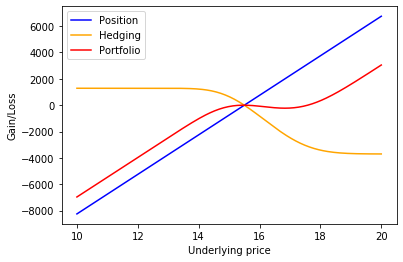

In [40]:
S=np.linspace(10,20,200)
P=1500*S-1500*15.5
BoughtCalls=[0]*len(S)
SoldCalls=[0]*len(S)
Spreads=[0]*len(S)
PortFolio=[0]*len(S)
plt.plot(S,P,label="Position",color="blue")
for i in range(len(S)):
    BoughtCalls[i]=20*CallOptionPrice(100,S[i],17.5,0.01,0.25,0.1)
    SoldCalls[i]=20*CallOptionPrice(100,S[i],15,0.01,0.25,0.1)
    Spreads[i]=BoughtCalls[i]-SoldCalls[i]+20*SpreadPrice
    PortFolio[i]=P[i]+Spreads[i]
plt.plot(S,Spreads,label="Hedging",color="orange")
plt.plot(S,PortFolio,label="Portfolio",color="red")
plt.legend()
plt.xlabel("Underlying price")
plt.ylabel("Gain/Loss")

We can evaluate the opportunity cost of the hedging strategy:
$$
\textrm{OpportunityCost}=\textrm{PortFolio}+\textrm{Hedging}-\textrm{PortFolio}=\textrm{Hedging}
$$
So what? Let's look at some numbers:

In [41]:
[S[109],Spreads[109]]

[15.477386934673367, 34.10435909709577]

In [42]:
[S[110],Spreads[110]]

[15.527638190954775, -42.184353153960956]

And make a couple of interesting observations:
* When opportunity cost of hedging are negative we renounced to a gain, and we need that in exchange for risk reduction
* Delta hedging is a "local strategy", the region in which the hedging is effective is "small"
Well. Not that small. If we look at what coud happen in more than 1/1000 cases:

In [43]:
Sweek=np.linspace(15.5*(1+norm.ppf(0.001)*0.1*(1/52)**0.5),15.5*(1+norm.ppf(0.999)*0.1*(1/52)**0.5),200)

Where 1/1000 cases means that the price of the underlying S is in the range:
$$
S \in ( S_0 \times (1+ \Phi^{-1}(0.1\%) \sqrt{T}) , S_0 \times (1+\Phi^{-1}(0.1\%) \sqrt{T}) )
$$
and T is one week:

Text(0, 0.5, 'Gain/Loss')

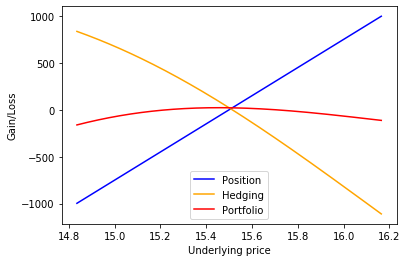

In [44]:
P=1500*Sweek-1500*15.5
BoughtCalls=[0]*len(Sweek)
SoldCalls=[0]*len(Sweek)
Spreads=[0]*len(Sweek)
PortFolio=[0]*len(Sweek)
plt.plot(Sweek,P,label="Position",color="blue")
for i in range(len(Sweek)):
    BoughtCalls[i]=20*CallOptionPrice(100,Sweek[i],17.5,0.01,0.25-1/52,0.1)
    SoldCalls[i]=20*CallOptionPrice(100,Sweek[i],15,0.01,0.25-1/52,0.1)
    Spreads[i]=BoughtCalls[i]-SoldCalls[i]+20*SpreadPrice
    PortFolio[i]=P[i]+Spreads[i]
plt.plot(Sweek,Spreads,label="Hedging",color="orange")
plt.plot(Sweek,PortFolio,label="Portfolio",color="red")
plt.legend()
plt.xlabel("Underlying price")
plt.ylabel("Gain/Loss")

We see that on a such small scale delta hedging is successful in reducing the volatility of the equities. It is also evident the similarity with the duration hedging in the interest rate case we looked at in the lesson.